# Project 2: How do perturbations to initial turning angle and electron density affect orbital stability?

## Introduction

The purpose of this project is to explore the orbital stability as a function of minor angular interference on a singular electron in $n$-Body systems with a fixed nucleus. The orbital stability of the system is defined as the average absolute standard deviation of the orbital distance of all electrons in the system over an angular period (that being, in the time that it takes the electron to reach the same angle with respect to the nucleus, how much does the distance that electron travels deviate on average). More stable systems will minimize this average deviation, and the value can be defined loosely from there.

In [1]:
from numpy.testing import *
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
from scipy.integrate import solve_ivp

In [2]:
NUM_PERIODS=10

# orbital radius of all of the electrons
r0 = 5.29e-11

# electron mass
m = 9.1e-31

# coulomb's constant
k = 9e9

# charge of an electron
q = 1.6e-19

# orbital velocity
v0 = np.sqrt(k * q ** 2 / (m * r0)) * 10

PERIOD = 2 * np.pi * r0 / v0

In [3]:
def rotate_vector_2d(vec, theta):
    rotation_matrix = \
        np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    return rotation_matrix @ vec

def unit_vector(v):
    return np.array(v) / np.linalg.norm(v)

def magnitudes(vector_list):
    return np.array([np.linalg.norm(vec) for vec in vector_list])

def unit_vectors(s):
    return np.array([unit_vector(v) for v in s])

In [4]:
def test_rotate_vector_2d():
    vec1 = np.array([1, 0])
    answer1 = np.array([0, 1])
    test1 = rotate_vector_2d(vec1, np.pi/2)
    assert_allclose(test1, answer1, atol=1e-12)
    print('(Test) `rotate_vector_2d` successful')

test_rotate_vector_2d()

def test_unit_vector():
    v1 = np.array([1,0])
    assert_allclose(unit_vector(v1), v1)
    v2 = np.array([1,1])
    assert_allclose(unit_vector(v2), v2/np.sqrt(2))
    print('(Test) `unit_vector` successful')
    
test_unit_vector()

def test_magnitudes():
    vs = np.array([[1,0],[0,1],
                   [1/np.sqrt(2),1/np.sqrt(2)],
                   [4/np.sqrt(2),4/np.sqrt(2)]])
    test = magnitudes(vs)
    assert_allclose(test, np.array([1, 1, 1, 4]))
    print('(Test) `magnitudes` successful')
    
test_magnitudes()

(Test) `rotate_vector_2d` successful
(Test) `unit_vector` successful
(Test) `magnitudes` successful


In [5]:
def cartesian_to_polar(coords):
    """
    Convert an array of 2D Cartesian coordinates to polar coordinates.
    coords can be shape (2,) or (N, 2)
    Returns an array of shape (2,) or (N, 2): [r, theta]
    """
    coords = np.asarray(coords)

    if coords.ndim == 1:
        x, y = coords
        r = np.sqrt(x**2 + y**2)
        theta = np.arctan2(y, x)
        return np.array([r, theta])

    elif coords.ndim == 2 and coords.shape[1] == 2:
        x = coords[:, 0]
        y = coords[:, 1]
        r = np.sqrt(x**2 + y**2)
        theta = np.arctan2(y, x)
        return np.column_stack((r, theta))

    else:
        raise ValueError(f"Expected shape (2,) or (N,2), got {coords.shape}")

In [6]:
def test_cartesian_to_polar():
    test1 = cartesian_to_polar([[ np.sqrt(2)/2, np.sqrt(2)/2 ], 
                                [ 1,            0            ],
                                [ 0,            1            ]])
    ideal1 = np.array([[ 1, np.pi/4 ], [ 1, 0 ], [ 1, np.pi/2 ]])
    assert_allclose(test1, ideal1)
    print('(Test) `cartesian_to_polar` successful')
    
test_cartesian_to_polar()

(Test) `cartesian_to_polar` successful


In [7]:
@dataclass
class ElectronState:
    pos: np.array = None
    vel: np.array = None
    
def interpret_state(state):
    pos = np.array(state[0:2])
    vel = np.array(state[2:4])
        
    return ElectronState(pos, vel)

def set_state_index(state, i, pos, vel):
    base = 4 * i
    state[base : base + 4] = [pos[0], pos[1], vel[0], vel[1]]
    
def get_state(state, i):
    return state[4*i : 4*i + 4]
 
def get_electron(state, i):
    return interpret_state(get_state(state, i))

In [ ]:
def calculate_coulomb_force(distance_vec, attract=False):
    mag = k * q ** 2 / np.linalg.norm(distance_vec) ** 3 * distance_vec
        
    # reverse direction if it's attractive
    if attract:
        return mag
    else:
        return mag * -1

In [ ]:
def test_calculate_coulomb_force():
    # electron-electron
    electron_pos = np.array([r0, 0])
    proton_pos   = np.array([0,  0])

In [8]:
def test_interpret_state():
    example_state = [ 1, 2, 3, 4 ]
    interpretation = interpret_state(example_state)
    assert_allclose(interpretation.pos, np.array([1, 2]))
    assert_allclose(interpretation.vel, np.array([3, 4]))
    print('(Test) `interpret_state` successful')
    
test_interpret_state()
    
def test_set_state_index():
    example_state = np.zeros(12)
    set_state_index(example_state, 1, np.array([1, 2]), np.array([3, 4]))
    assert_allclose(example_state, np.array([0, 0, 0, 0, 1, 2, 3, 4, 0, 0, 0, 0]))
    print('(Test) `set_state_index` successful')

test_set_state_index()
    
def test_get_state():
    example_state = np.array([0, 0, 0, 0, 1, 2, 3, 4, 0, 0, 0, 0])
    test = get_state(example_state, 1)
    assert_allclose(test, np.array([1, 2, 3, 4]))
    print('(Test) `get_state` successful')
    
test_get_state()
    
def test_get_electron():
    example_state = np.array([0, 0, 0, 0, 1, 2, 3, 4, 0, 0, 0, 0])
    test = get_electron(example_state, 1)
    assert_allclose(test.pos, np.array([1, 2]))
    assert_allclose(test.vel, np.array([3, 4]))
    print('(Test) `get_electron` successful')
    
test_get_electron()

(Test) `interpret_state` successful
(Test) `set_state_index` successful
(Test) `get_state` successful
(Test) `get_electron` successful


In [9]:
def generate_initial_state(n, incidence_angle=None):
    """
    Produces the initial state to match the number 
    of electrons and the incidence angle
    """
    state = np.zeros(4 * (n + 1))
    dtheta = 2 * np.pi / (n + 1)
    for i, theta in enumerate(np.linspace(0, 2 * np.pi, n + 1, endpoint=False)):
        pos = r0 * np.array([ np.cos(theta), np.sin(theta)])
        vel = v0 * np.array([-np.sin(theta), np.cos(theta)])
        set_state_index(state, i, pos, vel)
    
    # apply an incidence angle to the interest electron 
    # (always at theta=0) if the user supplied one
    if incidence_angle is not None:
        vel = np.array(state[2:4])
        rotated = rotate_vector_2d(vel, incidence_angle)
        state[2] = rotated[0]
        state[3] = rotated[1]
        
    return state

In [10]:
def test_generate_initial_state():
    trivial = generate_initial_state(0)
    assert_allclose(trivial, np.array([r0, 0, 0, v0]))
    incidence_angle = generate_initial_state(0, -np.pi/2)
    assert_allclose(incidence_angle, np.array([r0, 0, v0, 0]), atol=1e-6)
    print('(Test) `generate_initial_state` successful')
    
test_generate_initial_state()

(Test) `generate_initial_state` successful


In [11]:
def align_periods_by_angle(angular_positions, radial_positions, period_indices, tol=np.pi*1e-3):
    # Split into separate periods
    start_indices = np.concatenate(([0], period_indices + 1))
    end_indices = np.concatenate((period_indices + 1, [len(angular_positions)]))
    
    angle_periods = [angular_positions[s:e] for s, e in zip(start_indices, end_indices)]
    radius_periods = [radial_positions[s:e] for s, e in zip(start_indices, end_indices)]

    # Choose the first period as the reference
    ref_angles = angle_periods[0]
    n_periods = len(angle_periods)
    aligned_radii = np.full((n_periods, len(ref_angles)), np.nan)

    # Fill aligned matrix
    for i in range(n_periods):
        for j, ref_angle in enumerate(ref_angles):
            diff = np.abs(angle_periods[i] - ref_angle)
            idx = np.where(diff < tol)[0]
            if len(idx) > 0:
                aligned_radii[i, j] = radius_periods[i][idx[0]]

    return ref_angles, aligned_radii

In [12]:
def test_align_periods_by_angle():
    angles = np.concatenate([
        np.linspace(0, 2*np.pi, 5, endpoint=False),
        np.linspace(0, 2*np.pi, 5, endpoint=False) + np.random.uniform(-0.01, 0.01, 5),
        np.linspace(0, 2*np.pi, 5, endpoint=False) + np.random.uniform(-0.01, 0.01, 5)
    ])
    
    radii = np.concatenate([
        np.linspace(1,   2,   5),
        np.linspace(1.1, 2.1, 5),
        np.linspace(0.9, 1.9, 5)
    ])
    
    period_indices_auto   = np.where(np.diff(angles) < 0)[0]
    period_indices_actual = np.array([4, 9])
    
    assert_allclose(period_indices_auto, period_indices_actual)
    ref_angles, aligned_radii = align_periods_by_angle(angles, radii, period_indices_auto)

    print("Reference Angles:", np.round(ref_angles,    3))
    print("Aligned Radii:\n",  np.round(aligned_radii, 2))
    
test_align_periods_by_angle()

Reference Angles: [0.    1.257 2.513 3.77  5.027]
Aligned Radii:
 [[1.   1.25 1.5  1.75 2.  ]
 [ nan  nan 1.6   nan 2.1 ]
 [0.9   nan  nan  nan  nan]]


In [13]:
def calculate_period_deviation(angular_trajectory):
    r     = angular_trajectory[:, 0]
    theta = angular_trajectory[:, 1]
    
    # split into periods based on where the derivative of the angle goes from negative to positive
    period_indices = np.where(np.diff(np.sign(np.sin(theta))) < 0)[0]
    
    if len(period_indices) < 2:
        return 0
    
    deviations = []
    for i in range(1, len(period_indices)):
        start, end = period_indices[i-1], period_indices[i]
        segment = r[start:end]
        deviations.append(np.std(segment))
        
    return np.mean(deviations)

In [14]:
def test_calculate_period_deviation():
    angular_trajectory = np.array([
        [ 1, 2/3,     1/3,     0.,        1/3,   2/3,       1,       1, 2/3-0.1, 1/3-0.2, 0.-0.3,    1/3-0.4, 2/3-0.5,   1-0.6    ],
        [ 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 3*np.pi/2, 2*np.pi, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi,   3*np.pi/2, 2*np.pi, ]
    ])
    test = calculate_period_deviation(angular_trajectory)
    
    radial_positions  = angular_trajectory[0]
    angular_positions = angular_trajectory[1]
    
    period_indices = np.where(np.diff(angular_positions) < 0)[0]
    
    
    #np.assert_equal(test, actual)
    
test_calculate_period_deviation()

In [15]:
@dataclass
class ElectronData:
    pos:            np.array = None
    radial_pos:     np.array = None
    vel:            np.array = None
    
    kinetic_energy:   np.array = None
    potential_energy: np.array = None
    momentum:         np.array = None

@dataclass
class CalculationResult:
    time:            np.array   = None
    electrons:       list       = None
    stability_score: np.float64 = -1
    
    total_kinetic_energy:    np.array = None
    total_potential_energy:  np.array = None
    total_mechanical_energy: np.array = None
    total_momentum:          np.array = None

def calculate(n, angle, num_periods=NUM_PERIODS, rtol=1e-9, atol=1e-9):
    state0 = generate_initial_state(n, angle)
    t_span = (0, num_periods * PERIOD)
    n_electrons = n + 1

    def diff_eqns(t, state):
        # state is a flat 1D array of length 4*n
        state_delta = np.zeros_like(state)

        for i in range(n_electrons):
            electron = get_electron(state, i)

            # attractive net force contribution from the nucleus
            net_force = calculate_coulomb_force(electron.pos, attract=True)

            # repulsive net force contribution from the other electrons
            for j in range(n_electrons):
                if i == j:
                    continue

                other = get_electron(state, j)
                net_force += calculate_coulomb_force(electron.pos - other.pos)

            accel = net_force / m
            set_state_index(state_delta, i, electron.vel, accel)

        return state_delta


    calculation = solve_ivp(diff_eqns, t_span, state0, rtol=rtol, atol=atol)
    
    results = CalculationResult()
    results.time = np.array(calculation.t)
    results.electrons = []
    
    for i in range(n_electrons):
        electron = get_electron(calculation.y, i)
        pos = electron.pos.transpose()
        vel = electron.vel.transpose()
        radial_pos = cartesian_to_polar(pos)
        
        potential_energy = np.zeros_like(results.time)
        kinetic_energy = (1/2) * m * magnitudes(vel) ** 2
        momentum       = m * magnitudes(vel)
        
        results.electrons.append(ElectronData(pos, radial_pos, vel, \
                                              kinetic_energy, potential_energy, momentum))
    
    results.stability_score      = np.mean([calculate_period_deviation(electron.radial_pos) \
                                            for electron in results.electrons])
    results.total_kinetic_energy = np.sum([electron.kinetic_energy \
                                           for electron in results.electrons], axis=0)
    results.total_potential_energy  = np.sum([electron.potential_energy \
                                              for electron in results.electrons], axis=0)
    results.total_mechanical_energy = results.total_kinetic_energy + results.total_potential_energy
    
    results.total_momentum = np.sum([electron.momentum for electron in results.electrons], axis=0)
    
    return results

[[5.29000000e-11 0.00000000e+00]
 [5.29000000e-11 2.41803703e-16]
 [5.29000000e-11 2.65984073e-15]
 [5.29000001e-11 2.68402110e-14]
 [5.29000068e-11 2.68643925e-13]
 [5.29002615e-11 1.66366656e-12]
 [5.29012751e-11 3.67527501e-12]
 [5.29034526e-11 6.05396262e-12]
 [5.29071812e-11 8.74659204e-12]
 [5.29129762e-11 1.17900783e-11]
 [5.29218124e-11 1.53501783e-11]
 [5.29355126e-11 1.97126015e-11]
 [5.29521648e-11 2.40761208e-11]
 [5.29697751e-11 2.80692088e-11]
 [5.29892649e-11 3.20265360e-11]
 [5.30111615e-11 3.60850141e-11]
 [5.30359459e-11 4.03338231e-11]
 [5.30642193e-11 4.48610454e-11]
 [5.30968301e-11 4.97758122e-11]
 [5.31351180e-11 5.52395665e-11]
 [5.31816066e-11 6.15490147e-11]
 [5.32435082e-11 6.95549841e-11]
 [5.33113243e-11 7.79584839e-11]
 [5.33814963e-11 8.63654153e-11]
 [5.34535087e-11 9.47687475e-11]
 [5.35297602e-11 1.03480243e-10]
 [5.36116160e-11 1.12668319e-10]
 [5.37001730e-11 1.22460827e-10]
 [5.37964991e-11 1.32976722e-10]
 [5.39017252e-11 1.44338069e-10]
 [5.401709

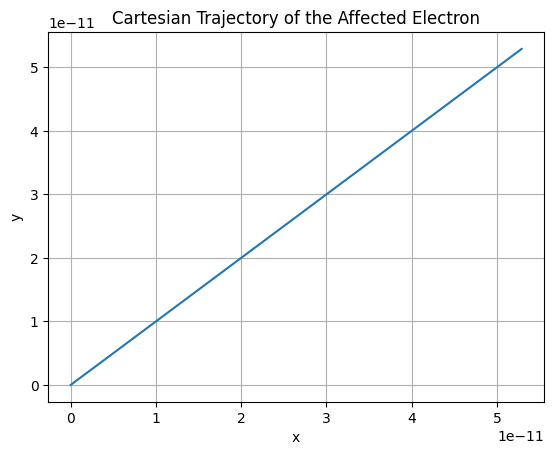

In [19]:
def test_calculation_raw():
    trivial_state = generate_initial_state(0, 0)
    
    def diff_eqns(t, state):
        state_delta = np.zeros_like(state)
        electron = get_electron(state, 0)
        net_force = calculate_coulomb_force(electron.pos, attract=True)
        accel = net_force / m
        set_state_index(state_delta, 0, electron.vel, accel)

        return state_delta
    
    calculation = solve_ivp(diff_eqns, (0, PERIOD), trivial_state, rtol=1e-9, atol=1e-9)
    electron = get_electron(calculation.y, 0)
    
    pos = electron.pos.transpose()
    vel = electron.vel.transpose()
    radial_pos = cartesian_to_polar(pos)
    
    plt.figure()
    plt.plot(pos[0], pos[1])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Cartesian Trajectory of the Affected Electron')
    plt.grid(True)
    
test_calculation_raw()

In [ ]:
from dataclasses import dataclass
from PIL import Image
import io

@dataclass
class Visualizations:
    radial_trajectory:    Image = None
    cartesian_trajectory: Image = None
    energy:               Image = None
    calc:                 CalculationResult = None
    
def simulate(n, angle, plot=False):
    def save_graph_and_close():
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        graph = Image.open(buf)
        plt.close()
        return graph

    sim = calculate(n, angle)
    affected_electron = sim.electrons[0]
    
    figures = Visualizations()
    
    plt.figure()
    plt.plot(affected_electron.radial_pos[1], affected_electron.radial_pos[0])
    plt.xlabel('θ (rad)')
    plt.ylabel('Radial Distance from Nucleus (m)')
    plt.title(f'Radial Trajectory of 10 orbits for the Affected Electron')
    plt.grid(True)
    figures.radial_trajectory = save_graph_and_close()
    
    plt.figure()
    plt.plot(affected_electron.pos[0], affected_electron.pos[1])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Cartesian Trajectory of the Affected Electron')
    plt.grid(True)
    figures.cartesian_trajectory = save_graph_and_close()

    plt.figure()
    plt.plot(sim.time, affected_electron.kinetic_energy, label="Kinetic Energy")
    plt.plot(sim.time, sim.total_kinetic_energy,         label='Total Kinetic Energy')
    plt.plot(sim.time, sim.total_potential_energy,       label='Total Potential Energy')
    plt.plot(sim.time, sim.total_mechanical_energy,      label='Total Mechanical Energy')
    plt.xlabel("Time (s)")
    plt.ylabel("Energy (J)")
    plt.title("Energy vs Time")
    plt.legend()
    plt.grid(True)
    figures.energy = save_graph_and_close()
    
    figures.calc = sim
    
    return figures

In [ ]:
test = simulate(n=3, angle=0)
display(test.radial_trajectory)

In [ ]:
test.calc.electrons[0].pos

In [ ]:
display(test.cartesian_trajectory)

In [ ]:
display(test.energy)

In [ ]:
def generate_contour(n_domain, theta_domain, debug_print=False):            
    A, S = np.meshgrid(n_domain, theta_domain, indexing='ij')
    Z = np.zeros_like(A, dtype=float)
    total_sims = len(n_domain) * len(theta_domain)
    idx = 0
    interval = total_sims // 10
    for i, n in enumerate(n_domain):
        for j, theta in enumerate(theta_domain):
            idx += 1
            if debug_print and idx % interval == 0:
                print(f'{(idx / total_sims) * 100:.0f}% - Iteration {idx}/{total_sims}')
            Z[i,j] = calculate(n, theta).stability_score
    
    plt.figure()
    cp = plt.contourf(A, S, Z, levels=20, cmap='viridis')
    plt.colorbar(cp, label='Stability')
    plt.xlabel('Number of Electrons')
    plt.ylabel('Perturbation Angle (rad)')
    plt.title('Stability Score')
    plt.show()

In [ ]:
"""
generate_contour(n_domain     = [1, 2, 3, 4, 5],
                 theta_domain = np.linspace(-np.pi/6, np.pi/6, 10),
                 debug_print  = True)
"""